# FYS-STK 4155 H20 PROJECT 1

## Definitions

In [1]:
from utils import *
from ole import *
from ridge import *
from lasso import *

/home/olav/anaconda3/envs/fys-stk4155/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
NOISE = .05
NUM_SAMPLES = 1000
MAX_POLY_ORDER = 15
NUM_BOOTSTRAPS = 20
np.random.seed(0)

### OLS bias-variance tradeoff

In [3]:
x, y = randmesh(sn=NUM_SAMPLES)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)
z, f, var_eps = franke_sampler(x.T[0], y.T[0], noise=NOISE)

ols_bs_df = DataFrame(columns=["pol order", "train mse", "mse", "bias", "var"])

for pn in range(MAX_POLY_ORDER):
    Xpn = truncate_to_poly(X, pn)
    results = ols_bootstrap(Xpn, z, f, train_size=.7, bootstraps=NUM_BOOTSTRAPS)
    ols_bs_df.loc[pn] = [pn, *results]

print(best_r2(ols_bs_df["mse"], z))

0.9418669932012874


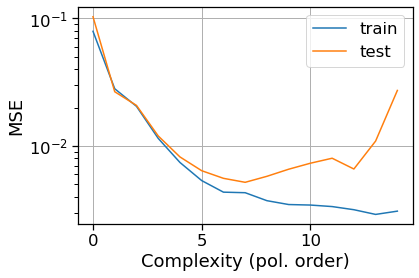

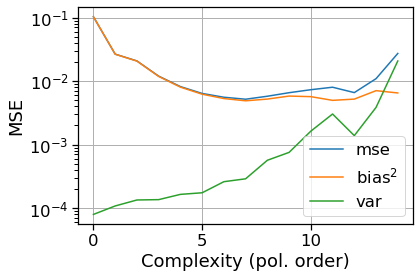

In [4]:
ax = ols_bs_df.plot(x="pol order", y=["train mse", "mse"], logy=True)
ax.legend(["train", "test"])
ax.set_xlabel("Complexity (pol. order)")
ax.set_ylabel("MSE")

ax.grid(True)
plt.show()

ax = ols_bs_df.plot(x="pol order", y=["mse", "bias", "var"], logy=True)
ax.legend(["mse", "bias$^2$", "var"])
ax.set_xlabel("Complexity (pol. order)")
ax.set_ylabel("MSE")
#ax.set_xlim(0,15)
#ax.set_ylim(1E-4,1)
ax.grid(True)
plt.show()

## OLS with $k$-fold cross-validation resampling
The data is randomized, so we don't need to do that again.

### OLS train vs. test MSE

In [5]:
x, y = randmesh(sn=NUM_SAMPLES)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)
z, f, var_eps = franke_sampler(x.T[0], y.T[0], noise=NOISE)

ols_k_df = DataFrame(columns=["pol order", "train", "test"])

for pn in range(MAX_POLY_ORDER):
    Xpn = truncate_to_poly(X, pn)
    results = ols_kfold(Xpn, z, k=25)
    ols_k_df.loc[pn] = [pn, *results]

print(best_r2(ols_k_df["test"], z))

0.9180617507321158


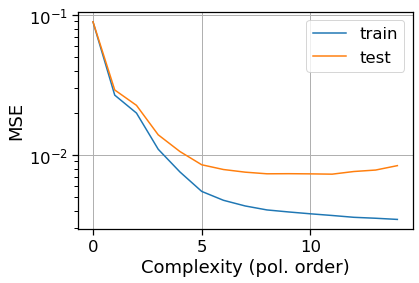

In [6]:
ax = ols_k_df.plot(x="pol order", logy=True)
ax.set_xlabel("Complexity (pol. order)")
ax.set_ylabel("MSE")

ax.grid(True)
plt.show()

## Ridge with bootstrap resampling

### Ridge bias-variance tradeoff

In [7]:
x, y = randmesh(sn=10000)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)
z, f, var_eps = franke_sampler(x.T[0], y.T[0], noise=NOISE)

lambdas = np.logspace(-4, 2, 500)
polynomial_orders = list(range(10, 22+1, 3))

test_cols = [f"mse_{pn} bias_{pn} var_{pn}" for pn in polynomial_orders]
test_cols = " ".join(test_cols)
test_cols = test_cols.split()

ridge_bs_df = DataFrame(columns=["lambda", "train"] + test_cols)
ridge_bs_df["lambda"] = lambdas

for pn in polynomial_orders:
    Xpn = truncate_to_poly(X, pn)
    mse_train, mse_test, bias_test, var_test = ridge_bootstrap(Xpn, z, f, lambdas=lambdas, train_size=.5, bootstraps=NUM_BOOTSTRAPS)
    ridge_bs_df[f"train"] = mse_train
    ridge_bs_df[f"mse_{pn}"] = mse_test
    ridge_bs_df[f"bias_{pn}"] = bias_test
    ridge_bs_df[f"var_{pn}"] = var_test

In [8]:
pn = 13
print(best_r2(ridge_bs_df[f"mse_{pn}"], z))

0.8376977081929301


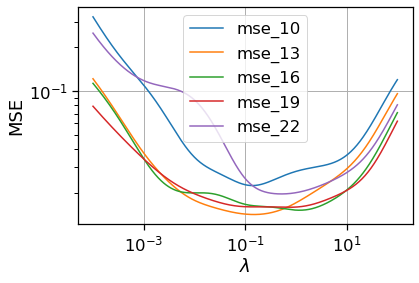

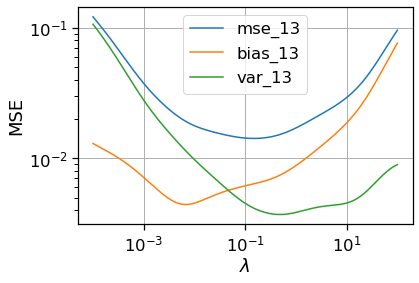

In [9]:
ax = ridge_bs_df.plot(x="lambda", y=[f"mse_{pn}" for pn in polynomial_orders], logy=True, logx=True)
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.grid(True)

ax = ridge_bs_df.plot(x="lambda", y=[f"mse_{pn}", f"bias_{pn}", f"var_{pn}"], logy=True, logx=True)
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.grid(True)

plt.show()

## Ridge with $k$-fold cross-validation resampling

### Ridge train vs. test MSE

In [10]:
#%%timeit -n1 -r1
x, y = randmesh(sn=10000)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)
z, f, var_eps = franke_sampler(x.T[0], y.T[0], noise=NOISE)

lambdas = np.logspace(-7, 2, 50)
polynomial_orders = list(range(3, MAX_POLY_ORDER+1, 3))

test_cols = [f"train_{pn} test_{pn}" for pn in polynomial_orders]
test_cols = " ".join(test_cols)
test_cols = test_cols.split()

ridge_k_df = DataFrame(columns=["lambda"] + test_cols)
ridge_k_df["lambda"] = lambdas

for pn in polynomial_orders:
    Xpn = truncate_to_poly(X, pn)
    mse_train, mse_test = ridge_kfold(Xpn, z, lambdas=lambdas, k=25)
    ridge_k_df[f"train_{pn}"] = mse_train
    ridge_k_df[f"test_{pn}"] = mse_test

print(best_r2(ridge_k_df[f"test_{pn}"], z))

0.9166726221327344


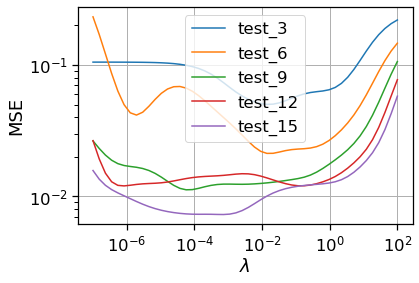

In [11]:
ax = ridge_k_df.plot(x="lambda", y=[f"test_{pn}" for pn in polynomial_orders], logy=True, logx=True)
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.grid(True)

In [12]:
#plt.figure(figsize=(10,5))
#sns.heatmap(DataFrame(Vt.T @ np.linalg.inv(S**2 + L) @ S @ U.T))

In [13]:
#plt.figure(figsize=(10,5))
#sns.heatmap(DataFrame(Vt.T @ np.linalg.pinv(X_resampled)))

## LASSO with bootstrap resampling

In [14]:
#%%timeit -n1 -r1
x, y = randmesh(sn=1000)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)
z, f, var_eps = franke_sampler(x.T[0], y.T[0], noise=NOISE)

lambdas = np.logspace(-7, 1, 30)
polynomial_orders = list(range(3,MAX_POLY_ORDER+1, 3))
#polynomial_orders = [6]

test_cols = [f"mse_{pn} bias_{pn} var_{pn}" for pn in polynomial_orders]
test_cols = " ".join(test_cols)
test_cols = test_cols.split()

lasso_bs_df = DataFrame(columns=["lambda", "train"] + test_cols)
lasso_bs_df["lambda"] = lambdas

for pn in polynomial_orders:
    Xpn = truncate_to_poly(X, pn)
    mse_train, mse_test, bias_test, var_test = lasso_bootstrap(Xpn, z, f, lambdas=lambdas, train_size=.7, bootstraps=5, max_iter=1E5, warm_start=True, precompute=True)
    lasso_bs_df[f"train"] = mse_train
    lasso_bs_df[f"mse_{pn}"] = mse_test
    lasso_bs_df[f"bias_{pn}"] = bias_test
    lasso_bs_df[f"var_{pn}"] = var_test


In [15]:
pn = 9
print(best_r2(lasso_bs_df[f"mse_{pn}"], z))

0.9345153996191757


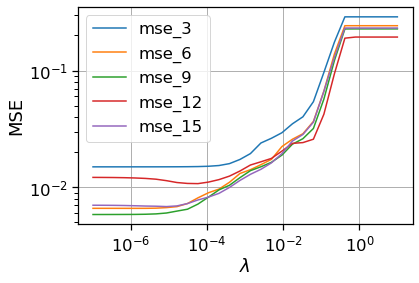

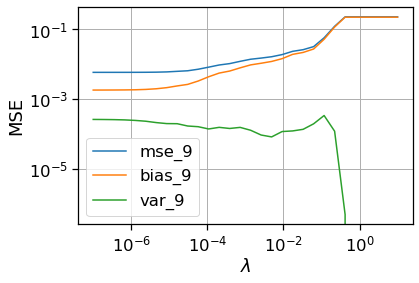

In [16]:

ax = lasso_bs_df.plot(x="lambda", y=[f"mse_{pn}" for pn in polynomial_orders], logy=True, logx=True)
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.grid(True)

pn = pn
ax = lasso_bs_df.plot(x="lambda", y=[f"mse_{pn}", f"bias_{pn}", f"var_{pn}"], logy=True, logx=True)
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.grid(True)

plt.show()

In [8]:
from utils import *
from ole import *
from ridge import *
from lasso import *

NOISE = .05
NUM_SAMPLES = 1000
MAX_POLY_ORDER = 15
NUM_BOOTSTRAPS = 20
np.random.seed(0)

In [19]:
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

@ignore_warnings(category=ConvergenceWarning)
def lasso_kfold(X, z, lambdas=[], k=50, **kwargs):
    '''Performs LASSO regression with k-fold split on X, z. Returns tuple=(train MSE, test MSE)'''
    splits = split(z, k)

    num_lambdas = len(lambdas)
    mse_train = np.ndarray(num_lambdas)
    mse_test = np.ndarray(num_lambdas)

    mse_train_buf = np.ndarray(k)
    mse_test_buf = np.ndarray(k)

    for i, lmd in enumerate(lambdas):
        lasso = skl.linear_model.Lasso(alpha=lmd, fit_intercept=False, **kwargs)
        
        for j, (train_split, test_split) in enumerate(zip(*splits)):
            X_train = X[train_split]
            z_train = z[train_split]
            X_test = X[test_split]
            z_test = z[test_split]

            n, p = X_train.shape
            X_train = X_train[:p,:p]
            z_train = z_train[:p]
            X_test = X_test[:p,:p]
            z_test = z_test[:p]

            scaler = skl.preprocessing.StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
            X_train[:,0] = 1
            X_test[:,0] = 1

            lasso.fit(X_train, z_train)
            beta_hat = np.ndarray((X_train.shape[1], 1))
            beta_hat[:,0] = lasso.coef_

            mse_train_buf[j] = mse(z_train, X_train @ beta_hat)
            mse_test_buf[j] = mse(z_test, X_test @ beta_hat)

        mse_train[i] = np.mean(mse_train_buf)
        mse_test[i] = np.mean(mse_test_buf)

    return (mse_train, mse_test)

In [81]:
#%%timeit -n1 -r1
x, y = randmesh(sn=10000)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)
z, f, var_eps = franke_sampler(x.T[0], y.T[0], noise=NOISE)

lambdas = np.logspace(-6, 0, 50)
polynomial_orders = list(range(3, MAX_POLY_ORDER+1, 3))
#polynomial_orders = [15]

test_cols = [f"train_{pn} test_{pn}" for pn in polynomial_orders]
test_cols = " ".join(test_cols)
test_cols = test_cols.split()

lasso_k_df = DataFrame(columns=["lambda"] + test_cols)
lasso_k_df["lambda"] = lambdas

for pn in polynomial_orders:
    Xpn = truncate_to_poly(X, pn)
    mse_train, mse_test = lasso_kfold(Xpn, z, lambdas=lambdas, k=50, max_iter=1E4, warm_start=True, precompute=True, tol=.01)
    lasso_k_df[f"train_{pn}"] = mse_train
    lasso_k_df[f"test_{pn}"] = mse_test

print(best_r2(lasso_k_df[f"test_{pn}"], z))

0.9220324574825998


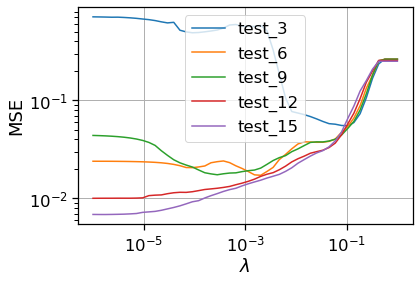

In [82]:
ax = lasso_k_df.plot(x="lambda", y=[f"test_{pn}" for pn in polynomial_orders], logy=True, logx=True)
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.grid(True)